f:\Aplikacje\Miniconda\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
f:\Aplikacje\Miniconda\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
f:\Aplikacje\Miniconda\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
f:\Aplikacje\Miniconda\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
f:\Aplikacje\Miniconda\envs\ml\Lib\site-packages

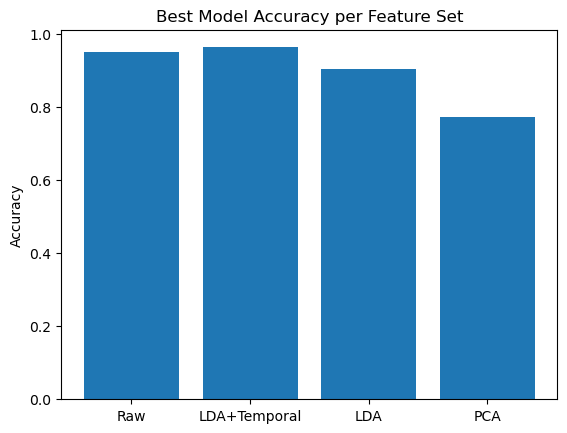

Feature Set: Raw, Model: NeuralNet
Accuracy: 0.9506826414042909
ROC AUC: 0
Classification Report: {'0': {'precision': 0.905688622754491, 'recall': 0.9279141104294478, 'f1-score': 0.9166666666666666, 'support': 652.0}, '1': {'precision': 0.9490445859872612, 'recall': 0.9445324881141046, 'f1-score': 0.9467831612390787, 'support': 631.0}, '2': {'precision': 0.9295352323838081, 'recall': 0.9077598828696926, 'f1-score': 0.9185185185185185, 'support': 683.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 426.0}, '4': {'precision': 0.9386281588447654, 'recall': 0.9420289855072463, 'f1-score': 0.9403254972875226, 'support': 552.0}, '5': {'precision': 0.9984520123839009, 'recall': 1.0, 'f1-score': 0.9992254066615027, 'support': 645.0}, 'accuracy': 0.9506826414042909, 'macro avg': {'precision': 0.9535581020590378, 'recall': 0.9537059111534152, 'f1-score': 0.9535865417288815, 'support': 3589.0}, 'weighted avg': {'precision': 0.9507809894627911, 'recall': 0.9506826414042909, '

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_pickle("../../data/partially processed/data_with_lda_pca.pkl")

# 2. Temporal abstraction (rolling mean example)
df['acc_x_roll'] = df.groupby('set')['acc_x'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['acc_y_roll'] = df.groupby('set')['acc_y'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['acc_z_roll'] = df.groupby('set')['acc_z'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_x_roll'] = df.groupby('set')['gyro_x'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_y_roll'] = df.groupby('set')['gyro_y'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
df['gyro_z_roll'] = df.groupby('set')['gyro_z'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)


# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Split features
X_raw = df[['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']]
X_temporal = df[['acc_x_roll','acc_y_roll','acc_z_roll','gyro_x_roll','gyro_y_roll','gyro_z_roll']]
X_lda = df[['lda_1','lda_2','lda_3']]
X_pca = df[['pca_1','pca_2','pca_3']]
y = df['label_encoded']

# 3. Combine features for sets
# (1) raw acc+gyro
set1 = X_raw
# (2) lda + temporal
set2 = pd.concat([X_lda, X_temporal], axis=1)
# (3) lda only
set3 = X_lda
# (4) pca only
set4 = X_pca

feature_sets = [set1, set2, set3, set4]
feature_set_names = ["Raw", "LDA+Temporal", "LDA", "PCA"]

# 4. Feature selection with Decision Tree
def select_features(X, y):
    dt = DecisionTreeClassifier()
    dt.fit(X, y)
    return dt.feature_importances_

# 5. Grid search for multiple classifiers
models = {
    "DecisionTree": (DecisionTreeClassifier(), {"max_depth":[3,5,7]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators":[10,50,100], "min_samples_split":[2,5,10,30,60,100]}),
}

# 6. Train and evaluate
results = {}
for fs_name, fs_data in zip(feature_set_names, feature_sets):
    X_train, X_test, y_train, y_test = train_test_split(fs_data, y, test_size=0.3, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    best_score = 0
    best_model = None
    for name, (model, params) in models.items():
        gs = GridSearchCV(model, params, cv=3, scoring='accuracy')
        gs.fit(X_train_sc, y_train)
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = (name, gs.best_estimator_)

    # Evaluate best
    pred = best_model[1].predict(X_test_sc)
    report = classification_report(y_test, pred, output_dict=True)
    roc = 0
    try:
        prob = best_model[1].predict_proba(X_test_sc)[:,1]
        roc = roc_auc_score(y_test, prob, multi_class='ovr')
    except:
        pass

    results[fs_name] = {
        "model": best_model[0],
        "accuracy": report["accuracy"],
        "classification_report": report,
        "roc_auc": roc
    }

# 7. Plot results
fig, ax = plt.subplots()
x_vals = np.arange(len(results))
acc_vals = [results[k]["accuracy"] for k in results]
ax.bar(x_vals, acc_vals, tick_label=list(results.keys()))
ax.set_ylabel("Accuracy")
ax.set_title("Best Model Accuracy per Feature Set")
plt.show()

# Print final
for fs_name, info in results.items():
    print(f"Feature Set: {fs_name}, Model: {info['model']}")
    print("Accuracy:", info['accuracy'])
    print("ROC AUC:", info['roc_auc'])
    print("Classification Report:", info['classification_report'])
    print("------------------------------------")
    
    
